In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

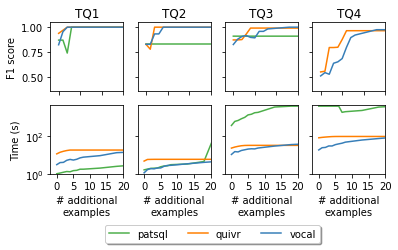

In [3]:
def plot_query_median(dataset_name):
    query_strs = [
    "Conjunction(Near_1(o0, o1), BottomQuadrant(o0))",
    "Far_3(o0, o1); Near_1(o0, o1); Far_3(o0, o1)",
    "Far_3(o0, o1); Conjunction(Near_1(o0, o1), Behind(o0, o1))",
    "Far_3(o0, o1); Conjunction(Conjunction(Near_1(o0, o1), LeftQuadrant(o0)), Behind(o0, o1))",
#     "Conjunction(FrontOf(o0, o1), TopQuadrant(o0))",
#     "Near_1(o0, o1); Far_3(o0, o1)",
#     "Conjunction(Conjunction(Near_1(o0, o1), LeftQuadrant(o0)), Behind(o0, o1))",
#     "Conjunction(Far_3(o0, o1), BottomQuadrant(o0)); Near_1(o0, o1)",
#     "Conjunction(Far_3(o0, o1), LeftQuadrant(o0)); Conjunction(Near_1(o0, o1), LeftQuadrant(o0))",
    ]
    exp_dir = "/gscratch/balazinska/enhaoz/complex_event_video/src/quivr/outputs/{}".format(dataset_name)
    
    fig, axs = plt.subplots(2, len(query_strs), figsize = (6, 2.8))
    
    for idx, query_str in enumerate(query_strs):
    
        # PATSQL
        try:
            with open(os.path.join(exp_dir, "stats", "PATSQL", "{}.json".format(query_str)), "r") as f:
                patsql_stats = json.load(f)
            patsql_runtime = patsql_stats["runtime"]
            patsql_f1 = patsql_stats["score"]
            patsql_x = np.array(list(range(12, 21)) + list(range(25, 51, 5))) - 12
            patsql_f1 = np.array(patsql_f1)
            if np.all(patsql_f1 == -1):
                patsql_f1 = np.zeros_like(patsql_f1)
            else:
                patsql_f1[patsql_f1 == -1] = np.nan # replace -1 with nan
                patsql_f1[:, np.all(np.isnan(patsql_f1), axis=0)] = 0 # If all values are nan, replace with 0
            patsql_runtime = np.array(patsql_runtime)
    #         patsql_runtime[patsql_runtime > 3600] = np.nan 

            patsql_f1_25 = np.nanpercentile(patsql_f1, 25, axis=0)
            patsql_f1_50 = np.nanpercentile(patsql_f1, 50, axis=0)
            patsql_f1_75 = np.nanpercentile(patsql_f1, 75, axis=0)

            patsql_runtime_25 = np.percentile(patsql_runtime, 25, axis=0)
            patsql_runtime_50 = np.percentile(patsql_runtime, 50, axis=0)
            patsql_runtime_75 = np.percentile(patsql_runtime, 75, axis=0)
            axs[0, idx].plot(patsql_x, patsql_f1_50, marker='o', markersize=0, label="patsql", color=CB_color_cycle[2])
#             axs[0, idx].fill_between(patsql_x, patsql_f1_25, patsql_f1_75, facecolor='tab:orange', alpha=0.3)
            axs[1, idx].plot(patsql_x, patsql_runtime_50, marker='o', markersize=0, label="patsql", color=CB_color_cycle[2])
#             axs[1, idx].fill_between(patsql_x, patsql_runtime_25, patsql_runtime_75, facecolor='tab:orange', alpha=0.3)
        except:
            pass


        # Quivr without kleene
        try:
            count_failed = 0
            quivr_f1 = []
            quivr_runtime = []
            for run in range(20):
                with open(os.path.join(exp_dir, 
                                       "stats", 
                                       "quivr_original_no_kleene/nip_2-nin_10-npred_5-n_nontrivial_None-n_trivial_None-depth_3-max_d_1-thread_1-lru_None",
                                       "{}-{}.json".format(query_str, run)), "r") as f:
                    quivr_stats = json.load(f)
                quivr_runtime_per_run = quivr_stats["runtime"]
                quivr_f1_per_run = quivr_stats["score_median"]
                if sum(quivr_f1_per_run) / len(quivr_f1_per_run) == -1:
                    count_failed += 1
                    continue
                quivr_f1.append(quivr_f1_per_run)
                quivr_runtime.append(quivr_runtime_per_run)

            quivr_x = np.array(list(range(12, 51))) - 12 
            quivr_f1 = np.array(quivr_f1)
            quivr_f1_25 = np.percentile(quivr_f1, 25, axis=0)
            quivr_f1_50 = np.percentile(quivr_f1, 50, axis=0)
            quivr_f1_75 = np.percentile(quivr_f1, 75, axis=0)
            quivr_runtime = np.array(quivr_runtime)
            quivr_runtime_25 = np.percentile(quivr_runtime, 25, axis=0)
            quivr_runtime_50 = np.percentile(quivr_runtime, 50, axis=0)
            quivr_runtime_75 = np.percentile(quivr_runtime, 75, axis=0)
            axs[0, idx].plot(quivr_x, quivr_f1_50, marker='s', markersize=0, label="quivr", color=CB_color_cycle[1])
#             axs[0, idx].fill_between(quivr_x, quivr_f1_25, quivr_f1_75, facecolor='tab:blue', alpha=0.3)
            axs[1, idx].plot(quivr_x, quivr_runtime_50, marker='s', markersize=0, label="quivr", color=CB_color_cycle[1])
#             axs[1, idx].fill_between(quivr_x, quivr_runtime_25, quivr_runtime_75, facecolor='tab:blue', alpha=0.3)
        except :
            pass
        
        # VOCAL
        try:
            with open(os.path.join(exp_dir, "stats", "vocal_postgres-topk", "{}.json".format(query_str)), "r") as f:
                vocal_finegrained_cache_stats = json.load(f)
            vocal_finegrained_cache_runtime = vocal_finegrained_cache_stats["runtime"]
            vocal_finegrained_cache_f1 = vocal_finegrained_cache_stats["score_median"]
            vocal_finegrained_cache_x = np.array(list(range(12, 21)) + list(range(25, 51, 5))) - 12 
            vocal_finegrained_cache_f1 = np.array(vocal_finegrained_cache_f1)
            vocal_finegrained_cache_f1_25 = np.percentile(vocal_finegrained_cache_f1, 25, axis=0)
            vocal_finegrained_cache_f1_50 = np.percentile(vocal_finegrained_cache_f1, 50, axis=0)
            vocal_finegrained_cache_f1_75 = np.percentile(vocal_finegrained_cache_f1, 75, axis=0)
            vocal_finegrained_cache_runtime = np.array(vocal_finegrained_cache_runtime)
            vocal_finegrained_cache_runtime_25 = np.percentile(vocal_finegrained_cache_runtime, 25, axis=0)
            vocal_finegrained_cache_runtime_50 = np.percentile(vocal_finegrained_cache_runtime, 50, axis=0)
            vocal_finegrained_cache_runtime_75 = np.percentile(vocal_finegrained_cache_runtime, 75, axis=0)
            axs[0, idx].plot(vocal_finegrained_cache_x, vocal_finegrained_cache_f1_50, marker='^', markersize=0, label="vocal", color=CB_color_cycle[0])
    #         axs[0].fill_between(vocal_finegrained_cache_x, vocal_finegrained_cache_f1_25, vocal_finegrained_cache_f1_75, facecolor='tab:brown', alpha=0.3)
            axs[1, idx].plot(vocal_finegrained_cache_x, vocal_finegrained_cache_runtime_50, marker='^', markersize=0, label="vocal", color=CB_color_cycle[0])
    #         axs[1].fill_between(vocal_finegrained_cache_x, vocal_finegrained_cache_runtime_25, vocal_finegrained_cache_runtime_75, facecolor='tab:brown', alpha=0.3)
        except:
            pass
        
        
        axs[0, idx].set(xlabel="# additional\nexamples", ylabel="F1 score")
        axs[0, idx].set_xlim(right=15)
        axs[0, idx].xaxis.set_ticks(np.arange(0, 20, 5))
        axs[0, idx].set_ylim(bottom=0.35, top=1.05)
        axs[0, idx].title.set_text("TQ{}".format(idx+1))
        axs[1, idx].set(xlabel="# additional\nexamples", ylabel="Time (s)")
        axs[1, idx].set_xlim(right=15)
        axs[1, idx].xaxis.set_ticks(np.arange(0, 21, 5))
#         axs[1, idx].set_ylim(top=200)
        axs[1, idx].set_ylim(bottom=1, top=4000)
        axs[1, idx].set_yscale('log')
        
    
    for ax in axs.flat:
        ax.label_outer()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, prop={"size":10}, loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=4)
#     plt.subplots_adjust(bottom=0.15)
    plt.savefig("figures/simplified_TQ1-4.pdf", bbox_inches='tight', pad_inches=0, dpi=600)
plot_query_median("without_duration-sampling_rate_4")

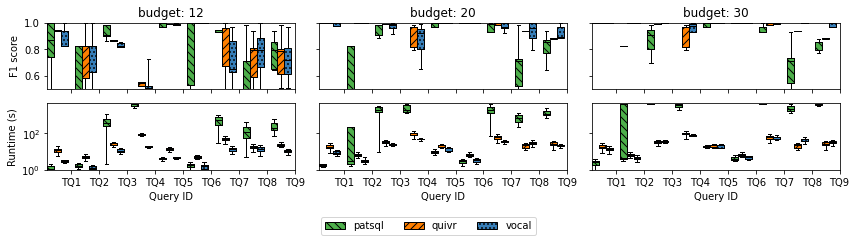

In [4]:
def plot_query_median_boxplot(dataset_name, budgets):
    query_strs = [
    "Conjunction(Near_1(o0, o1), BottomQuadrant(o0))",
    "Far_3(o0, o1); Near_1(o0, o1); Far_3(o0, o1)",
    "Far_3(o0, o1); Conjunction(Near_1(o0, o1), Behind(o0, o1))",
    "Far_3(o0, o1); Conjunction(Conjunction(Near_1(o0, o1), LeftQuadrant(o0)), Behind(o0, o1))",
    "Conjunction(FrontOf(o0, o1), TopQuadrant(o0))",
    "Near_1(o0, o1); Far_3(o0, o1)",
    "Conjunction(Conjunction(Near_1(o0, o1), LeftQuadrant(o0)), Behind(o0, o1))",
    "Conjunction(Far_3(o0, o1), BottomQuadrant(o0)); Near_1(o0, o1)",
    "Conjunction(Far_3(o0, o1), LeftQuadrant(o0)); Conjunction(Near_1(o0, o1), LeftQuadrant(o0))",
    ]
    
    exp_dir = "/gscratch/balazinska/enhaoz/complex_event_video/src/quivr/outputs/{}".format(dataset_name)

#     fig, ax = plt.subplots(figsize = (6, 2))
    fig, axs = plt.subplots(2, len(budgets), figsize = (12, 3)) 
    
    for col_id, budget in enumerate(budgets):
        
        query_id = ["TQ{}".format(i) for i in range(1, 10)]
        handles_f1 = []
        handles_runtime = []
        legend_labels = []

        # PATSQL
        patsql_f1_data = []
        patsql_runtime_data = []
        for query_str in query_strs:
            patsql_f1 = []
            patsql_runtime = []
            try:
                with open(os.path.join(exp_dir, "stats", "PATSQL", "{}.json".format(query_str)), "r") as f:
                    patsql_stats = json.load(f)
                patsql_x = list(range(12, 21)) + list(range(25, 51, 5))
                x_idx = patsql_x.index(budget)
                patsql_runtime = np.array(patsql_stats["runtime"])
                patsql_f1 = np.array(patsql_stats["score"])
                if np.all(patsql_f1 == -1):
                    patsql_f1 = np.zeros_like(patsql_f1)
                else:
                    patsql_f1[patsql_f1 == -1] = np.nan # replace -1 with nan
                    patsql_f1[:, np.all(np.isnan(patsql_f1), axis=0)] = 0 # If all values are nan, replace with 0
                patsql_f1 = patsql_f1[:, x_idx]
                patsql_runtime = patsql_runtime[:, x_idx]
                patsql_f1 = patsql_f1[~np.isnan(patsql_f1)]
                patsql_runtime = patsql_runtime[~np.isnan(patsql_runtime)]
            except Exception as err:
                print(err)
                pass
            patsql_f1_data.append(patsql_f1)
            patsql_runtime_data.append(patsql_runtime)
            bp_f1_patsql = axs[0, col_id].boxplot(patsql_f1_data, 
                           positions=np.array(range(len(patsql_f1_data)))*4.0-3, 
                           sym='.', widths=1, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[2], hatch = '\\\\\\'),
                           medianprops = dict(color='black'))
            bp_runtime_patsql = axs[1, col_id].boxplot(patsql_runtime_data, 
                           positions=np.array(range(len(patsql_runtime_data)))*4.0-3, 
                           sym='.', widths=1, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[2], hatch = '\\\\\\'),
                           medianprops = dict(color='black'))
        handles_f1.append(bp_f1_patsql["boxes"][0])
        handles_runtime.append(bp_runtime_patsql["boxes"][0])
        legend_labels.append("patsql")

        # Quivr
        quivr_f1_data = []
        quivr_runtime_data = []
        for query_str in query_strs:
            quivr_f1 = []
            quivr_runtime = []
            try:
                for run in range(20):
                    with open(os.path.join(exp_dir, 
                                           "stats", 
                                           "quivr_original_no_kleene/nip_2-nin_10-npred_5-n_nontrivial_None-n_trivial_None-depth_3-max_d_1-thread_1-lru_None",
                                           "{}-{}.json".format(query_str, run)), "r") as f:
                        quivr_stats = json.load(f)
                    quivr_runtime_per_run = quivr_stats["runtime"]
                    quivr_f1_per_run = quivr_stats["score_median"]
                    quivr_f1.append(quivr_f1_per_run)
                    quivr_runtime.append(quivr_runtime_per_run)

                quivr_x = list(range(12, 51))
                x_idx = quivr_x.index(budget)
                quivr_f1 = np.array(quivr_f1)
                quivr_runtime = np.array(quivr_runtime)
                quivr_f1 = quivr_f1[:, x_idx]
                quivr_runtime = quivr_runtime[:, x_idx]        
            except Exception as err:
                print(err)
                pass
            quivr_f1_data.append(quivr_f1)
            quivr_runtime_data.append(quivr_runtime)
            bp_f1_quivr = axs[0, col_id].boxplot(quivr_f1_data, 
                           positions=np.array(range(len(quivr_f1_data)))*4-2, 
                           sym='.', widths=1, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[1], hatch = '///'),
                           medianprops = dict(color='black'))
            bp_runtime_quivr = axs[1, col_id].boxplot(quivr_runtime_data, 
                           positions=np.array(range(len(quivr_runtime_data)))*4-2,
                           sym='.', widths=1, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[1], hatch = '///'),
                           medianprops = dict(color='black'))
        handles_f1.append(bp_f1_quivr["boxes"][0])
        handles_runtime.append(bp_runtime_quivr["boxes"][0])
        legend_labels.append("quivr")

        # VOCAL
        f1_data = []
        runtime_data = []
        for query_str in query_strs:
            f1 = []
            runtime = []
            try:
                with open(os.path.join(exp_dir, "stats", "vocal_postgres-topk", "{}.json".format(query_str)), "r") as f:
                    stats = json.load(f)
                x = list(range(12, 21)) + list(range(25, 51, 5))
                x_idx = x.index(budget)
                runtime = np.array(stats["runtime"])
                f1 = np.array(stats["score_median"])
                f1 = f1[:, x_idx]
                runtime = runtime[:, x_idx]
                f1 = f1[~np.isnan(f1)]
                runtime = runtime[~np.isnan(runtime)]
            except:
                pass
            f1_data.append(f1)
            runtime_data.append(runtime)
            bp_f1 = axs[0, col_id].boxplot(f1_data, 
                           positions=np.array(range(len(f1_data)))*4.0-1, 
                           sym='.', widths=1, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[0], hatch = '...'),
                           medianprops = dict(color='black'))
            bp_runtime = axs[1, col_id].boxplot(runtime_data, 
                           positions=np.array(range(len(runtime_data)))*4.0-1, 
                           sym='.', widths=1, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[0], hatch = '...'),
                           medianprops = dict(color='black'))
    #         for box in bp_f1['boxes']:
    #             box.set(hatch = 'x', fill=False)    
        handles_f1.append(bp_f1["boxes"][0])
        handles_runtime.append(bp_runtime["boxes"][0])
        legend_labels.append("vocal")
              
                                           
        axs[0, col_id].set(xlabel="Query ID", ylabel="F1 score")
    #     axs[0].legend(handles=handles_f1, labels=legend_labels, loc='upper center', 
    #                   bbox_to_anchor=(0.5, -0.2), prop={"size":10}, fancybox=True, shadow=True, ncol=2)
        axs[0, col_id].set_ylim(bottom=0.5, top=1)
        axs[0, col_id].set_xticks(range(0, len(query_id)*4, 4), query_id)
        axs[0, col_id].title.set_text("budget: {}".format(budget))
        
        axs[1, col_id].set(xlabel="Query ID", ylabel="Runtime (s)")
    #     axs[1].legend(prop={"size":10}, loc='upper center', bbox_to_anchor=(0.5, -0.2),
    #           fancybox=True, shadow=True, ncol=2)
#         axs[1, col_id].legend(handles=handles_runtime, labels=legend_labels, loc='upper center', 
#                       bbox_to_anchor=(0.5, -0.2), prop={"size":10}, fancybox=True, shadow=True, ncol=2)
        # axs[1].set_ylim(bottom=0)
        axs[1, col_id].set_ylim(bottom=1, top=4000)
        axs[1, col_id].set_yscale('log')
        axs[1, col_id].set_xticks(range(0, len(query_id)*4, 4), query_id)
    for ax in axs.flat:
        ax.label_outer()
    fig.legend(handles_runtime, legend_labels, prop={"size":10}, loc='upper center', bbox_to_anchor=(0.5, 0.0),
              fancybox=True, shadow=False, ncol=3)
    plt.title("")
    plt.subplots_adjust(bottom=0.15)
    fig.tight_layout()
#     plt.savefig("figures/simplified_boxplot.pdf", bbox_inches='tight', pad_inches=0, dpi=600)
                                           
plot_query_median_boxplot("without_duration-sampling_rate_4", budgets=[12, 20, 30])

budget: 12
patsql [0.8690476190476191, 0.8266666666666667, 0.9090909090909091, 0.0, 0.9694323144104803, 1.0, 0.9315068493150686, 0.41025641025641024, 0.7961876832844574]
quivr [0.9374999999999999, 0.8266666666666667, 0.870967741935484, 0.5472277227722773, 0.9909502262443439, 1.0, 0.6724137931034482, 0.7948717948717948, 0.7863247863247863]
vocal [0.821917808219178, 0.8266666666666667, 0.8244274809160306, 0.5066371681415929, 0.9842696629213483, 1.0, 0.6505398671096345, 0.7948717948717948, 0.7203170874926601]
budget: 20
patsql [1.0, 0.8266666666666667, 0.9090909090909091, 0.0, 0.9694323144104803, 1.0, 0.9315068493150686, 0.7083333333333333, 0.8514851485148516]
quivr [1.0, 1.0, 0.990909090909091, 0.9642857142857143, 1.0, 1.0, 0.9810126582278481, 0.9333333333333333, 0.881787126932758]
vocal [1.0, 1.0, 0.9821428571428572, 0.920463538722442, 1.0, 1.0, 0.9691358024691358, 0.9603174603174602, 0.8910152740341419]
budget: 30
patsql [1.0, 0.8266666666666667, 0.0, 0.0, 0.9694323144104803, 1.0, 0.0,

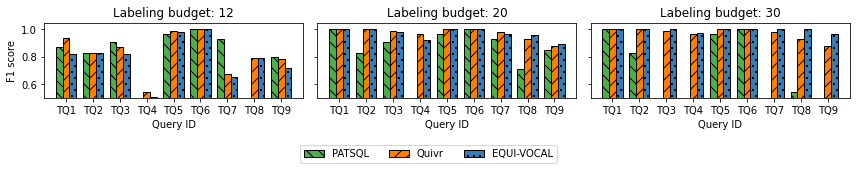

In [4]:
def plot_query_median_bar_chart(dataset_name, budgets):
    query_strs = [
    "Conjunction(Near_1(o0, o1), BottomQuadrant(o0))",
    "Far_3(o0, o1); Near_1(o0, o1); Far_3(o0, o1)",
    "Far_3(o0, o1); Conjunction(Near_1(o0, o1), Behind(o0, o1))",
    "Far_3(o0, o1); Conjunction(Conjunction(Near_1(o0, o1), LeftQuadrant(o0)), Behind(o0, o1))",
    "Conjunction(FrontOf(o0, o1), TopQuadrant(o0))",
    "Near_1(o0, o1); Far_3(o0, o1)",
    "Conjunction(Conjunction(Near_1(o0, o1), LeftQuadrant(o0)), Behind(o0, o1))",
    "Conjunction(Far_3(o0, o1), BottomQuadrant(o0)); Near_1(o0, o1)",
    "Conjunction(Far_3(o0, o1), LeftQuadrant(o0)); Conjunction(Near_1(o0, o1), LeftQuadrant(o0))",
    ]
    
    exp_dir = "/gscratch/balazinska/enhaoz/complex_event_video/src/quivr/outputs/{}".format(dataset_name)
    
    fig, axs = plt.subplots(1, len(budgets), figsize = (12, 2)) 
    
    for col_id, budget in enumerate(budgets):
        print("budget:", budget)
        query_id = ["TQ{}".format(i) for i in range(1, 10)]
        handles_f1 = []
        handles_runtime = []
        legend_labels = []

        # PATSQL
        patsql_f1_data = []
        patsql_runtime_data = []
        for query_str in query_strs:
            patsql_f1 = []
            patsql_runtime = []
            try:
                with open(os.path.join(exp_dir, "stats", "PATSQL", "{}.json".format(query_str)), "r") as f:
                    patsql_stats = json.load(f)
                patsql_x = list(range(12, 21)) + list(range(25, 51, 5))
                x_idx = patsql_x.index(budget)
                patsql_runtime = np.array(patsql_stats["runtime"])
                patsql_f1 = np.array(patsql_stats["score"])
                if np.all(patsql_f1 == -1):
                    patsql_f1 = np.zeros_like(patsql_f1)
                else:
                    patsql_f1[patsql_f1 == -1] = 0 # replace -1 with nan
                    patsql_f1[:, np.all(np.isnan(patsql_f1), axis=0)] = 0 # If all values are nan, replace with 0
                patsql_f1 = patsql_f1[:, x_idx]
                patsql_runtime = patsql_runtime[:, x_idx]
                patsql_f1 = patsql_f1[~np.isnan(patsql_f1)]
                patsql_runtime = patsql_runtime[~np.isnan(patsql_runtime)]
            except Exception as err:
                print(err)
                pass
            patsql_f1_data.append(np.median(patsql_f1))
            patsql_runtime_data.append(np.median(patsql_runtime))
        axs[col_id].bar(np.array(range(len(patsql_f1_data)))*4-3, patsql_f1_data, 1, label="PATSQL", color=CB_color_cycle[2], hatch = '\\\\', edgecolor="black")
        print("patsql", patsql_f1_data)
        
        # Quivr
        quivr_f1_data = []
        quivr_runtime_data = []
        for query_str in query_strs:
            quivr_f1 = []
            quivr_runtime = []
            try:
                for run in range(20):
                    with open(os.path.join(exp_dir, 
                                           "stats", 
                                           "quivr_original_no_kleene/nip_2-nin_10-npred_5-n_nontrivial_None-n_trivial_None-depth_3-max_d_1-thread_1-lru_None",
                                           "{}-{}.json".format(query_str, run)), "r") as f:
                        quivr_stats = json.load(f)
                    quivr_runtime_per_run = quivr_stats["runtime"]
                    quivr_f1_per_run = quivr_stats["score_median"]
                    quivr_f1.append(quivr_f1_per_run)
                    quivr_runtime.append(quivr_runtime_per_run)

                quivr_x = list(range(12, 51))
                x_idx = quivr_x.index(budget)
                quivr_f1 = np.array(quivr_f1)
                quivr_runtime = np.array(quivr_runtime)
                quivr_f1 = quivr_f1[:, x_idx]
                quivr_runtime = quivr_runtime[:, x_idx]        
            except Exception as err:
                print(err)
                pass
            quivr_f1_data.append(np.median(quivr_f1))
            quivr_runtime_data.append(np.median(quivr_runtime))
        axs[col_id].bar(np.array(range(len(quivr_f1_data)))*4-2, quivr_f1_data, 1, label="Quivr", color=CB_color_cycle[1], hatch = '//', edgecolor="black")
        print("quivr", quivr_f1_data)
        
        # VOCAL
        f1_data = []
        runtime_data = []
        for query_str in query_strs:
            f1 = []
            runtime = []
            try:
                with open(os.path.join(exp_dir, "stats", "vocal_postgres-topk", "{}.json".format(query_str)), "r") as f:
                    stats = json.load(f)
                x = list(range(12, 21)) + list(range(25, 51, 5))
                x_idx = x.index(budget)
                runtime = np.array(stats["runtime"])
                f1 = np.array(stats["score_median"])
                f1 = f1[:, x_idx]
                runtime = runtime[:, x_idx]
                f1 = f1[~np.isnan(f1)]
                runtime = runtime[~np.isnan(runtime)]
            except:
                pass
            f1_data.append(np.median(f1))
            runtime_data.append(np.median(runtime))  
        axs[col_id].bar(np.array(range(len(f1_data)))*4-1, f1_data, 1, label="EQUI-VOCAL", color=CB_color_cycle[0], hatch = '..', edgecolor="black")                                
        axs[col_id].set(xlabel="Query ID", ylabel="F1 score")
        axs[col_id].set_ylim(bottom=0.5, top=1.05)
        axs[col_id].set_xticks(range(-2, len(query_id)*4-2, 4), query_id)
        axs[col_id].title.set_text("Labeling budget: {}".format(budget))
        print("vocal", f1_data)
            
    for ax in axs.flat:
        ax.label_outer()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, prop={"size":10}, loc='upper center', bbox_to_anchor=(0.5, 0.0),
              fancybox=True, shadow=False, ncol=3)
    plt.subplots_adjust(bottom=0.15)
    fig.tight_layout()
    
    plt.savefig("figures/simplified_bar_chart.pdf", bbox_inches='tight', pad_inches=0, dpi=600)
                                           
plot_query_median_bar_chart("without_duration-sampling_rate_4", budgets=[12, 20, 30])

quivr success: 15 (75\%)
quivr success: 20 (100\%)
quivr success: 13 (65\%)
quivr success: 11 (55\%)
quivr success: 4 (20\%)
quivr success: 13 (65\%)
quivr success: 15 (75\%)
quivr success: 16 (80\%)
quivr success: 16 (80\%)
quivr success: 15 (75\%)
quivr success: 5 (25\%)
quivr success: 8 (40\%)
quivr success: 11 (55\%)
quivr success: 1 (5\%)
quivr success: 13 (65\%)
quivr success: 11 (55\%)
quivr success: 11 (55\%)
quivr success: 10 (50\%)


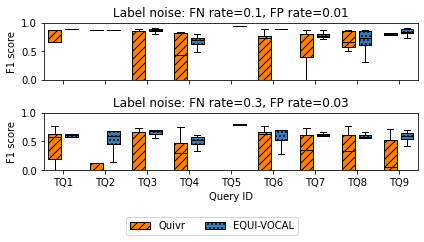

In [5]:
def plot_query_median_noisy(fnr_list, budget):
    fig, axs = plt.subplots(2, 1, figsize = (6, 3))
    for row_id, fnr in enumerate(fnr_list):
        dataset_name = "without_duration-sampling_rate_4-fn_error_rate_{}-fp_error_rate_{}".format(fnr, fnr/10)
        query_strs = [
        "Conjunction(Near_1(o0, o1), BottomQuadrant(o0))",
        "Far_3(o0, o1); Near_1(o0, o1); Far_3(o0, o1)",
        "Far_3(o0, o1); Conjunction(Near_1(o0, o1), Behind(o0, o1))",
        "Far_3(o0, o1); Conjunction(Conjunction(Near_1(o0, o1), LeftQuadrant(o0)), Behind(o0, o1))",
        "Conjunction(FrontOf(o0, o1), TopQuadrant(o0))",
        "Near_1(o0, o1); Far_3(o0, o1)",
        "Conjunction(Conjunction(Near_1(o0, o1), LeftQuadrant(o0)), Behind(o0, o1))",
        "Conjunction(Far_3(o0, o1), BottomQuadrant(o0)); Near_1(o0, o1)",
        "Conjunction(Far_3(o0, o1), LeftQuadrant(o0)); Conjunction(Near_1(o0, o1), LeftQuadrant(o0))",
        ]

        exp_dir = "/gscratch/balazinska/enhaoz/complex_event_video/src/quivr/outputs/{}".format(dataset_name)



        query_id = ["TQ{}".format(i) for i in range(1, 10)]
        handles_f1 = []
        handles_runtime = []
        legend_labels = []

        # Quivr with kleene
        quivr_f1_data = []
        quivr_runtime_data = []
        for query_str in query_strs:
            quivr_f1 = []
            quivr_runtime = []
            try:
                count_failed = 0
                count_success = 0
                quivr_with_kleene_f1 = []
                quivr_with_kleene_runtime = []
                for run in range(20):
                    with open(os.path.join(exp_dir, 
                                           "stats", 
                                           "quivr_original_no_kleene/nip_2-nin_10-npred_5-n_nontrivial_None-n_trivial_None-depth_3-max_d_1-thread_1-lru_None",
                                           "{}-{}.json".format(query_str, run)), "r") as f:
                        quivr_stats = json.load(f)
                    quivr_runtime_per_run = quivr_stats["runtime"]
                    quivr_f1_per_run = quivr_stats["score_median"]

                    if sum(quivr_f1_per_run) == 0:
                        count_failed += 1
                    else: 
                        count_success += 1
                    quivr_f1.append(quivr_f1_per_run)
                    quivr_runtime.append(quivr_runtime_per_run)

                print("quivr success: {} ({}\%)".format(count_success, int(count_success*100/20)))
                quivr_x = list(range(12, 51))
                x_idx = quivr_x.index(budget)
                quivr_f1 = np.array(quivr_f1)
                quivr_runtime = np.array(quivr_runtime)
                quivr_f1 = quivr_f1[:, x_idx]
                quivr_runtime = quivr_runtime[:, x_idx]        
            except Exception as err:
                print(err)
                pass
            quivr_f1_data.append(quivr_f1)
            quivr_runtime_data.append(quivr_runtime)
            bp_f1_quivr = axs[row_id].boxplot(quivr_f1_data, 
                           positions=np.array(range(len(quivr_f1_data)))*2.0-0.4, 
                           sym='.', widths=0.6, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[1], hatch = '///'),
                           medianprops = dict(color='black'))
        handles_f1.append(bp_f1_quivr["boxes"][0])
        legend_labels.append("Quivr")

        # VOCAL
        f1_data = []
        runtime_data = []
        for query_str in query_strs:
            f1 = []
            runtime = []
            try:
                with open(os.path.join(exp_dir, "stats", "vocal_postgres-topk", "{}.json".format(query_str)), "r") as f:
                    stats = json.load(f)
                x = list(range(12, 21)) + list(range(25, 51, 5))
                x_idx = x.index(budget)
                runtime = np.array(stats["runtime"])
                f1 = np.array(stats["score_median"])
                f1 = f1[:, x_idx]
                runtime = runtime[:, x_idx]
                f1 = f1[~np.isnan(f1)]
                runtime = runtime[~np.isnan(runtime)]
            except:
                pass
            f1_data.append(f1)
            runtime_data.append(runtime)
            bp_f1 = axs[row_id].boxplot(f1_data, 
                           positions=np.array(range(len(f1_data)))*2.0+0.4, 
                           sym='.', widths=0.6, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[0], hatch = '...'),
                           medianprops = dict(color='black'))
    #         for box in bp_f1['boxes']:
    #             box.set(hatch = 'x', fill=False)    
        handles_f1.append(bp_f1["boxes"][0])
        legend_labels.append("EQUI-VOCAL")


        axs[row_id].set(xlabel="Query ID", ylabel="F1 score")
        axs[row_id].set_ylim(bottom=0, top=1)
        axs[row_id].set_xticks(range(0, len(query_id) * 2, 2), query_id)
        axs[row_id].title.set_text("Label noise: FN rate={}, FP rate={}".format(fnr, fnr/10))
        
    for ax in axs.flat:
        ax.label_outer()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles=handles_f1, labels=legend_labels, loc='upper center', 
                      bbox_to_anchor=(0.5, 0), prop={"size":10}, fancybox=True, shadow=False, ncol=2)
    plt.subplots_adjust(bottom=0.15)
    fig.tight_layout()
    plt.savefig("figures/noisy.pdf", bbox_inches='tight', pad_inches=0, dpi=600)

fnr_list = [0.1, 0.3]
plot_query_median_noisy(fnr_list=fnr_list, budget=20)